In [1]:
# %%
import os,argparse,natsort
import pandas as pd
import matplotlib.pyplot as plt
# display more columns
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [2]:
data_dir = '../p3torch_logs'

In [3]:

def generate_summary_stats_per_op(data_dir):

    root_to_files = {}
    for root, dirs, files in os.walk(data_dir):
        root_to_files[root] = files
    roots = sorted(root_to_files, key=lambda x: natsort.natsort_key(x.lower()))

    config_to_stats = {}

    # recursively find all the log files
    for root in roots:
        if 'e2e' in root:
            continue
        files = root_to_files[root]
        print(root)

        # root is in the format of /mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b1024_gpu4
        # get me the batch size and gpu count as 'b1024_gpu4
        root = root.rstrip('/')
        config = root.split('/')[-1]
        print(config)
        dataloader_config = 8


        combine_df = pd.DataFrame()
        for file in files:
            if 'worker_pid' in file:
                fp = os.path.join(root, file)
                #  read the log file as csv with no header
                df = pd.read_csv(fp, header=None)
                df.columns = ["name", "start", "dur"]

                # drop columns with name "start"
                df = df.drop(columns=["start"])

                # divide "dur" column by 1,000,000 to get time in ms
                df["dur"] = df["dur"] / 1000000
                # discard the rows with name starting with SBatch
                df = df[~df["name"].str.startswith("SBatch")]

                # concatenate all the dataframes
                combine_df = pd.concat([combine_df, df])

        # check if the dataframe is empty
        if combine_df.empty:
            continue

        stats_df = combine_df.groupby("name").agg(["sum"])

        # make the column names flat
        stats_df.columns = stats_df.columns.get_level_values(0)
        config_to_stats[dataloader_config] = stats_df
    
    return config_to_stats

        

In [4]:
# %%
print("All numbers are in ms")
config_to_stats = generate_summary_stats_per_op(data_dir)

All numbers are in ms
../p3torch_logs
p3torch_logs


In [5]:
# concat all the stats into one dataframe make keys a columns with name "config"
all_stats_df = pd.concat(config_to_stats).reset_index() 

In [6]:
all_stats_df.head(10)

,level_0,name,dur
0,8,SCast,363.379098
1,8,SCollation,1196.718200
2,8,SGaussianNoise,1085.471283
3,8,SLoadImage,12101.996013
4,8,SRandBalancedCrop,15306.178628
5,8,SRandFlip,738.834868
6,8,SRandomBrightnessAugmentation,132.086045


In [7]:
# replace the column name "level_0" with "config"
all_stats_df = all_stats_df.rename(columns={"level_0": "config"})
# replace the column name "dur" with "E2E elapsed time (ms)"
all_stats_df = all_stats_df.rename(columns={"dur": "E2E elapsed time (secs)"})
# replace the column name "name" with "Function"
all_stats_df = all_stats_df.rename(columns={"name": "Function"})
# cast config column as int
all_stats_df["config"] = all_stats_df["config"].astype(int)

In [8]:
# Strip leading 'S' in column 'Function'
all_stats_df['Function'] = all_stats_df['Function'].str.lstrip('S')

In [9]:
# remove column 'name' with 'STransform' 
all_stats_df = all_stats_df[~all_stats_df["Function"].str.startswith("Transform")]
# remove column 'name' with 'SCollation'
all_stats_df = all_stats_df[~all_stats_df["Function"].str.startswith("Collation")]
# remove SLoader
# all_stats_df = all_stats_df[~all_stats_df["Function"].str.startswith("Loader")]

In [10]:
all_stats_df.head(10)

,config,Function,E2E elapsed time (secs)
0,8,Cast,363.379098
2,8,GaussianNoise,1085.471283
3,8,LoadImage,12101.996013
4,8,RandBalancedCrop,15306.178628
5,8,RandFlip,738.834868
6,8,RandomBrightnessAugmentation,132.086045


In [11]:
# divide the column "E2E elapsed time (ms)" by 1000 to get time in seconds
all_stats_df["E2E elapsed time (secs)"] = all_stats_df["E2E elapsed time (secs)"] / 1000

In [12]:
print(all_stats_df.columns)

Index(['config', 'Function', 'E2E elapsed time (secs)'], dtype='object')


In [13]:
all_stats_df.head(len(all_stats_df))

,config,Function,E2E elapsed time (secs)
0,8,Cast,0.363379
2,8,GaussianNoise,1.085471
3,8,LoadImage,12.101996
4,8,RandBalancedCrop,15.306179
5,8,RandFlip,0.738835
6,8,RandomBrightnessAugmentation,0.132086


Text(0.5, 1.0, 'Preprocessing time per operation')

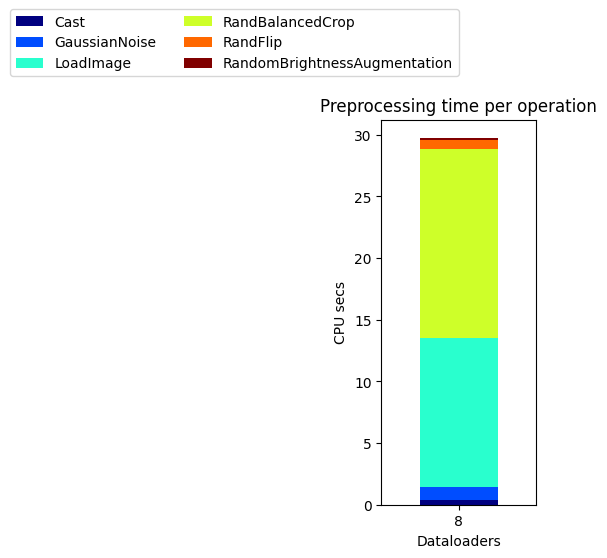

In [38]:
# plot stacked bar chart for each config
all_config_stacked = all_stats_df.groupby(['config', 'Function'])['E2E elapsed time (secs)'].sum().unstack()
all_config_stacked.plot.bar(stacked=True, colormap='jet', figsize=(2,5))
# put legend on the right of the plot
plt.legend(bbox_to_anchor=(0.5, 1.2), loc='right', borderaxespad=0., ncol=2)
# y axis is elapsed time in seconds
plt.ylabel('CPU secs')
# x axis is Dataloaders
plt.xlabel('Dataloaders')
# make x axis horizontal
plt.xticks(rotation=0)
# make title 
plt.title('Preprocessing time per operation')
# make legend horizontal on top of the title 


In [39]:
# all_config_stacked save as csv
all_config_stacked.to_csv('./all_config_stacked.csv')